# Generate publicaction quality figures of the results

## Setup

In [1]:
# General imports
import multiprocessing
import numpy as np
import pandas as pd
import time
import sys
import dill
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import collections
import os

In [2]:
# Add directory to sys.path in order to import custom modules from there.
sys.path.insert(0, "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/")
from gdsc_projects_module import DrugWithDrugBank, DrugGenomeWide, DrugWithGenesInSamePathways, Experiment, Modeling, ModelingResults

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Load general data

In [3]:
# Initialize proper file pathways
drug_annotations = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Drug annotations/Screened_Compounds-March_27th_2018.xlsx"
cell_line_list = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Cell line list (directly from website)/Cell_listThu Aug 16 22_06_49 2018.csv"
gene_expr = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Gene expression/sanger1018_brainarray_ensemblgene_rma-March_2nd_2017.txt"
cnv1 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/cnv_binary_1.csv"
cnv2 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/PANCANCER_Genetic_feature_cna_Mon Aug  6 16_18_51 2018 (kopia).csv"
coding_variants = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Mutation calls/PANCANCER_Genetic_feature_variant_Mon Aug  6 15_45_44 2018.csv"
drug_response = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Sensitivity profiles/v17.3_fitted_dose_response-March_27th_2018.xlsx"

# Load dictionary with targets derived from DrugBank
drugbank_targets = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/DrugBank/Created data/drugbank_map_drug_to_targets.p"

# Load dictionary mapping from target genes to genes that occur in same pathways
reactome_pathway_related_genes = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Reactome/Created Reactome Data/map_target_genes_to_genes_involved_in_same_pathways.pkl"

# Filepath to gene expression signatures provided by Merck
signatures = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Created data/Merck Gene Expression Signatures/Data/SignatureScores_GDSC-cellLines_2018-09-27.tsv"

# Call loading function from DrugWithGenesInSamePathways class
(drug_annotations_df, cell_lines_list_df, gene_expression_df, cnv_binary_df, 
 coding_variants_df, drug_response_df, map_drugs_to_drugbank_targets, 
 map_target_genes_to_same_pathways_genes) = DrugWithGenesInSamePathways.load_data(
    drug_annotations, cell_line_list, gene_expr, 
    cnv1, cnv2, coding_variants, drug_response, drugbank_targets, reactome_pathway_related_genes)

# Load gene expression signatures
signatures_df = pd.read_table(signatures)

# Load helper dict for extraction of CNV data
filepath = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/Created data/"
with open(filepath + "map_cl_id_and_genetic_feature_to_mutation_status.pkl", "rb") as f:
    map_from_cl_id_and_genetic_feature_to_mutation_status = dill.load(f)


# Load gene mappings
filepath1 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/GDSC - Prediction only with data related to nominal drug targets (minimal approach)/Created data/mapping_from_ensembl_id_to_hgnc_symbol.p"
filepath2 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/GDSC - Prediction only with data related to nominal drug targets (minimal approach)/Created data/mapping_from_hgnc_symbol_to_ensembl_id.p"
with open("../Results Assesment/Results and other files/mapper_from_ensembl_to_hgnc.pkl", "rb") as f:
    map_ensembl_to_hgnc = dill.load(f)
# Initialize class variables
DrugWithDrugBank.load_mappings(filepath2, filepath1)
DrugGenomeWide.load_mappings(filepath2, filepath1)
DrugWithGenesInSamePathways.load_mappings(filepath2, filepath1) 

# Print shapes of created DataFrames
print("Loading summary:")
print("Drug annotations:", drug_annotations_df.shape)
print("Cell line list", cell_lines_list_df.shape)
print("Gene expression", gene_expression_df.shape)
print("CNV binary:", cnv_binary_df.shape)
print("Coding variants:", coding_variants_df.shape)
print("Drug response:", drug_response_df.shape)
print("DrugBank mapping (number of matched drugs):", len(map_drugs_to_drugbank_targets))
print("Target gene mapping (number of target genes with match):", len(map_target_genes_to_same_pathways_genes))
print("Gene expression signatures:", signatures_df.shape)
print("Number of entries in mapping from cell line and cnv genetic feature to mutation status:",
     len(map_from_cl_id_and_genetic_feature_to_mutation_status))

Loading summary:
Drug annotations: (267, 5)
Cell line list (1065, 6)
Gene expression (17737, 1019)
CNV binary: (419050, 9)
Coding variants: (295740, 9)
Drug response: (224202, 13)
DrugBank mapping (number of matched drugs): 88
Target gene mapping (number of target genes with match): 200
Gene expression signatures: (128, 1018)
Number of entries in mapping from cell line and cnv genetic feature to mutation status: 419050


#### Create dictionary with Drug objects

In [4]:
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
print(len(drugs))

267


## Load ModelingResults objects (raw results)

In [5]:
# # Set directory with results
# filepath = "Final experimental raw results/"

# # Load only targets ENet
# with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
#     only_targets_enet = dill.load(f)
# print(type(only_targets_enet), len(only_targets_enet.performance_dict))

# # Load only targets RForest
# with open(filepath + "only_targets-rforest_over_few_data_splits.pkl", "rb") as f:
#     only_targets_rforest = dill.load(f)
# print(type(only_targets_rforest), len(only_targets_rforest.performance_dict))

# # Load only targets with signatures ENet
# with open(filepath + "only_targets_with_signatures-enet_over_few_data_splits.pkl", "rb") as f:
#     only_targets_with_signatures_enet = dill.load(f)
# print(type(only_targets_with_signatures_enet), len(only_targets_with_signatures_enet.performance_dict))

# # Load only targets with signatures RForest
# with open(filepath + "only_targets_with_signatures-rforest_over_few_data_splits.pkl", "rb") as f:
#     only_targets_with_signatures_rforest = dill.load(f)
# print(type(only_targets_with_signatures_rforest), len(only_targets_with_signatures_rforest.performance_dict))

# # Load pathway genes ENet
# with open(filepath + "pathway_genes-enet_over_few_data_splits.pkl", "rb") as f:
#     pathway_genes_enet = dill.load(f)
# print(type(pathway_genes_enet), len(pathway_genes_enet.performance_dict))

# # Load pathway genes RForest
# with open(filepath + "pathway_genes-rforest_over_few_data_splits.pkl", "rb") as f:
#     pathway_genes_rforest = dill.load(f)
# print(type(pathway_genes_rforest), len(pathway_genes_rforest.performance_dict))

# # Load pathway genes with signatures ENet
# with open(filepath + "pathway_genes_with_signatures-enet_over_few_data_splits_limited.pkl", "rb") as f:
#     pathway_genes_with_signatures_enet = dill.load(f)
# print(type(pathway_genes_with_signatures_enet), len(pathway_genes_with_signatures_enet.performance_dict))

# # Load pathway genes with signatures RForest
# with open(filepath + "pathway_genes_with_signatures-rforest_over_few_data_splits_limited.pkl", "rb") as f:
#     pathway_genes_with_signatures_rforest = dill.load(f)
# print(type(pathway_genes_with_signatures_rforest), len(pathway_genes_with_signatures_rforest.performance_dict))

# # Load genome-wide with feature selection ENet
# with open(filepath + "enet_with_standardscaler_and_feature_selection.pkl", "rb") as f:
#     genome_wide_with_selection_enet = dill.load(f)
# print(type(genome_wide_with_selection_enet), len(genome_wide_with_selection_enet.performance_dict))

# # Load genome-wide with feature selection RForest
# with open(filepath + "randomforest_with_standardscaler_and_feature_selection_without_importances.pkl", "rb") as f:
#     genome_wide_with_selection_rforest = dill.load(f)
# print(type(genome_wide_with_selection_rforest), len(genome_wide_with_selection_rforest.performance_dict))

# # Load genome-wide without feature selection ENet
# with open(filepath + "genome_wide-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
#     genome_wide_without_selection_enet = dill.load(f)
# print(type(genome_wide_without_selection_enet), len(genome_wide_without_selection_enet.performance_dict))

# # Load genome-wide without feature selection RForest
# with open(filepath + "genome_wide-rforest_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
#     genome_wide_without_selection_rforest = dill.load(f)
# print(type(genome_wide_without_selection_rforest), len(genome_wide_without_selection_rforest.performance_dict))

## Load DataFrames with results

In [6]:
! ls 'Results and other files'

aggregated_performance_all_models.csv
bad_drugs.pkl
best_results_from_two_groups.csv
best_results_per_drug_across_all_settings.csv
data_shapes_per_drug_in_models.csv
df_agg_all_drugs_restricted_vs_genome_wide.csv
df_best_results_per_drug_from_restricted_models.csv
drug_ids_to_keep_in_results.pkl
drug_response_df_with_pathways.csv
drugs_of_interest.csv
feature_importances_all_restricted_modelings.pkl
feature_importances_from_best_restricted_model_per_drug.pkl
gw_all_data_feat_list.pkl
gw_expression_feat_list.pkl
hue_order_all_models.pkl
intersection_of_drugs_between_models.pkl
mapper_from_ensembl_to_hgnc.pkl
modeling_gw_exps_alone_vs_gw_all_features.pkl
Notes.txt
palette_all_models.pkl
raw_performance_all_models.csv
set_of_all_analyzed_cell_lines.pkl
tp_names_abbrevations.pkl


In [7]:
# Load list containing IDs of bad drugs
with open("./Results and other files/bad_drugs.pkl", "rb") as f:
    bad_drugs = dill.load(f)
print(type(bad_drugs), len(bad_drugs))

<class 'list'> 19


In [8]:
# Load results for all settings, not aggregated over data splits
df_raw_all_models = pd.read_csv('./Results and other files/raw_performance_all_models.csv')
df_raw_all_models_filtered = df_raw_all_models[~df_raw_all_models["Drug ID"].isin(bad_drugs)]
print(df_raw_all_models.shape, df_raw_all_models_filtered.shape)
df_raw_all_models_filtered.head(3)

(12115, 11) (11215, 11)


,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
0,1,Erlotinib,11,0.088977,0.386896,4.561981e-05,0.096257,1.081822,EGFR signaling,OT EN,NaN
1,1,Erlotinib,37,0.061968,0.543188,2.138906e-09,0.070966,1.145203,EGFR signaling,OT EN,NaN
2,1,Erlotinib,52,0.096144,0.422583,7.103247e-06,0.103601,1.077567,EGFR signaling,OT EN,NaN


In [9]:
# Load results for all settings, aggregated over data splits
df_agg_all_models = pd.read_csv('./Results and other files/aggregated_performance_all_models.csv')
df_agg_all_models_filtered = df_agg_all_models[~df_agg_all_models["Drug ID"].isin(bad_drugs)]
print(df_agg_all_models.shape, df_agg_all_models_filtered.shape)
df_agg_all_models_filtered.head(3)

(2423, 9) (2243, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.086347,0.388664,0.001450,0.0924,1.075011,EGFR signaling,OT EN
1,1,Erlotinib,0.086797,0.356010,0.000767,0.0924,1.062901,EGFR signaling,PG EN
2,1,Erlotinib,0.086307,0.375711,0.000364,0.0924,1.071611,EGFR signaling,PG + S EN


In [10]:
# Load DataFrame with best results per drug across all settings
df_best_results = pd.read_csv("./Results and other files/best_results_per_drug_across_all_settings.csv")
df_best_results_filtered = df_best_results[~df_best_results["Drug ID"].isin(bad_drugs)]
print(df_best_results.shape, df_best_results_filtered.shape)
df_best_results_filtered.head(3)

(251, 9) (232, 9)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling


In [11]:
# Load intersection of drugs between all tested models
with open("./Results and other files/intersection_of_drugs_between_models.pkl", "rb") as f:
    drug_intersection = dill.load(f)
df_agg_intersection = df_agg_all_models[df_agg_all_models["Drug ID"].isin(drug_intersection)]
print(type(drug_intersection), len(drug_intersection), df_agg_intersection["Drug ID"].nunique())

<class 'list'> 175 175


In [12]:
# Load DataFrame with best results coming from two groups of models, unfiltered, for every drug in itersection
df_best_results_from_two_groups = pd.read_csv("./Results and other files/best_results_from_two_groups.csv")
df_best_results_from_two_groups_filtered = df_best_results_from_two_groups[
    ~df_best_results_from_two_groups["Drug ID"].isin(bad_drugs)]
print(df_best_results_from_two_groups.shape, df_best_results_from_two_groups_filtered.shape)
df_best_results_from_two_groups_filtered.head(3)

(350, 9) (324, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.085320,0.410257,0.000308,0.092400,1.086402,EGFR signaling,Restricted
1,1,Erlotinib,0.071460,0.374202,0.004133,0.073378,1.017662,EGFR signaling,Genome-wide
2,3,Rapamycin,0.223836,0.253258,0.042695,0.229805,1.027091,PI3K/MTOR signaling,Restricted


# Figures

In [14]:
# Setup some constants 
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

## Test stuff

In [15]:
# Set up constants
figure_width = 6.6929133858
ratio = 1.6
figure_height = figure_width / ratio

# Update rcParams
params = {
        'figure.figsize'      : [figure_width, figure_height] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

print(plt.rcParams.get('figure.figsize'))

[6.0, 4.0]


In [16]:
# Updating the params
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[6.6929133858, 4.183070866125]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [17]:
# If you want to go back do default settings
# plt.style.use("default")
# print(plt.rcParams.get('figure.figsize'))

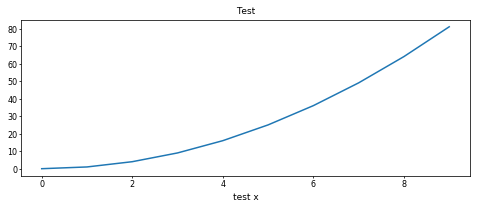

In [18]:
# Sample plot
x = np.arange(0, 10, 1)
y = x ** 2

plt.figure(figsize=(6.69, 2.95))
plt.title("Test")
plt.xlabel("test x")
sns.lineplot(x, y)

plt.tight_layout()
#plt.savefig("test_bigger.pdf")
plt.show()

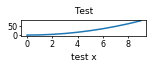

In [19]:
# Sample plot
x = np.arange(0, 10, 1)
y = x ** 2

plt.figure(figsize=(2.20, 1.))
plt.title("Test")
plt.xlabel("test x")
sns.lineplot(x, y)

plt.tight_layout()
#plt.savefig("test_smaller.pdf")
plt.show()

## Figure 1

- Half page width: 85 mm
- Full page width: 170 mm
- 170 mm corresponds to 6.6929133858 inches
- One inch: 25.4 mm

Four panels

In [13]:
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

In [14]:
# Constants for figure
mm_per_inch = 25.4
fig_width_in_mm = 170
fig_height_in_mm = 150

#### Panel 1
Boxplots of numbers of features and samples in different models

In [15]:
# Load DataFrame with data shapes
data_shapes_df = pd.read_csv("./Results and other files/data_shapes_per_drug_in_models.csv")
print(data_shapes_df.shape)
print(data_shapes_df.Model.unique())
data_shapes_df.head(6)

(1206, 5)
['Genome wide ENet' 'Genome wide RForest' 'Only targets'
 'Only targets with signatures' 'Pathway genes'
 'Pathway genes with signatures']


,Drug ID,Drug Name,Model,No. features,No. samples
0,1,Erlotinib,Genome wide ENet,638,370
1,1,Erlotinib,Genome wide RForest,50,370
2,1,Erlotinib,Only targets,5,347
3,1,Erlotinib,Only targets with signatures,133,347
4,1,Erlotinib,Pathway genes,530,347
5,1,Erlotinib,Pathway genes with signatures,658,347


In [16]:
# Set up constants
# Size in milimeters
panel_width_mm = 50.8
panel_height_mm = 50.8

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 50.8 2.0
Height: 50.8 2.0


In [17]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[2.0, 2.0]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [18]:
# Create a column with abbreviate of model
dic = {"Only targets": "OT",
      "Only targets with signatures": "OT + S",
      "Pathway genes": "PG",
      "Pathway genes with signatures": "PG + S",
      "Genome wide ENet": "GW SS",
      "Genome wide RForest": "GW RF"}
data_shapes_df["Model abbr"] = data_shapes_df.Model.map(dic)

In [19]:
# Establish order and color palette
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

color_indexes = []
color_order = ["OT RF", "OT + S RF", "PG RF", "PG + S RF", "GW RF", "GW EN"]

for mod in color_order:
    color_indexes.append(hue_order_all_models.index(mod))
print(color_indexes)
colors = [palette_all_models[i] for i in color_indexes]
order = ["OT", "OT + S", "PG", "PG + S", "GW RF", "GW SS"]

[11, 9, 7, 5, 1, 0]


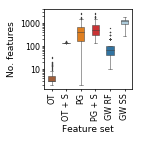

In [21]:
# Do the plotting
from matplotlib.ticker import ScalarFormatter


ax = sns.boxplot("Model abbr", y="No. features", data=data_shapes_df, 
                 linewidth=0.5,
                fliersize=0.5,
                width=0.5,
                order=order,
                palette=colors)

ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("Feature set")

plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(fig_directory + "fig1_boxplots_no_features.pdf")
plt.savefig(gimp_directory + "fig1_boxplots_no_features.pdf")


plt.show()

#### Panel 2
Boxplots of number of samples

In [22]:
# Load DataFrame with data shapes
data_shapes_df = pd.read_csv("./Results and other files/data_shapes_per_drug_in_models.csv")
print(data_shapes_df.shape)
print(data_shapes_df.Model.unique())
data_shapes_df.head(3)

(1206, 5)
['Genome wide ENet' 'Genome wide RForest' 'Only targets'
 'Only targets with signatures' 'Pathway genes'
 'Pathway genes with signatures']


,Drug ID,Drug Name,Model,No. features,No. samples
0,1,Erlotinib,Genome wide ENet,638,370
1,1,Erlotinib,Genome wide RForest,50,370
2,1,Erlotinib,Only targets,5,347


In [23]:
# Set up constants
# Size in milimeters
panel_width_mm = 50.8
panel_height_mm = 50.8

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 50.8 2.0
Height: 50.8 2.0


In [24]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[2.0, 2.0]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [25]:
data_shapes_df.Model.unique()

array(['Genome wide ENet', 'Genome wide RForest', 'Only targets',
       'Only targets with signatures', 'Pathway genes',
       'Pathway genes with signatures'], dtype=object)

In [26]:
# Create a column with abbreviate of model
dic = {"Only targets": "OT",
      "Only targets with signatures": "OT + S",
      "Pathway genes": "PG",
      "Pathway genes with signatures": "PG + S",
      "Genome wide ENet": "GW SS",
      "Genome wide RForest": "GW RF"}
data_shapes_df["Model abbr"] = data_shapes_df.Model.map(dic)

In [27]:
# Establish order and color palette
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

color_indexes = []
color_order = ["OT RF", "OT + S RF", "PG RF", "PG + S RF", "GW RF", "GW EN"]

for mod in color_order:
    color_indexes.append(hue_order_all_models.index(mod))
print(color_indexes)
colors = [palette_all_models[i] for i in color_indexes]
order = ["OT", "OT + S", "PG", "PG + S", "GW RF", "GW SS"]

[11, 9, 7, 5, 1, 0]


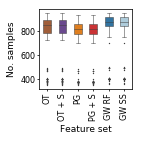

In [30]:
# Do the plotting
from matplotlib.ticker import ScalarFormatter

order = ["OT", "OT + S", "PG", "PG + S", "GW RF", "GW SS"]

ax = sns.boxplot("Model abbr", y="No. samples", data=data_shapes_df, 
                 linewidth=0.5,
                fliersize=0.5,
                width=0.5,
                order=order, palette=colors)

ax.set_xlabel("Feature set")

plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig(fig_directory + "fig1_boxplots_no_samples.pdf")
plt.savefig(gimp_directory + "fig1_boxplots_no_samples.pdf")

plt.show()

#### Panel 3
Boxplots of AUC distribution grouped by pathways

In [15]:
# Load drug response df with target pathways
response_df = pd.read_csv("./Results and other files/drug_response_df_with_pathways.csv")

In [16]:
# Load relevant drug IDs
with open("./Results and other files/drug_ids_to_keep_in_results.pkl", "rb") as f:
    relevant_drug_ids = dill.load(f)
print(len(relevant_drug_ids))

# Load relevant cell line IDs
with open("./Results and other files/set_of_all_analyzed_cell_lines.pkl", "rb") as f:
    relevant_cl_ids = dill.load(f)
print(type(relevant_cl_ids), len(relevant_cl_ids))

251
<class 'list'> 983


In [17]:
response_df = response_df[
    (response_df["DRUG_ID"].isin(relevant_drug_ids)) & (response_df["COSMIC_ID"].isin(relevant_cl_ids))
]
print(response_df.shape)

(201166, 14)


In [18]:
response_df.head()

,DATASET_VERSION,IC50_RESULTS_ID,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,MAX_CONC_MICROMOLAR,MIN_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,Z_SCORE,TARGET_PATHWAY
0,17.3,1,683665,MC-CAR,1,Erlotinib,EGFR,2.0,0.007812,2.453524,0.982610,0.021678,-0.015505,EGFR signaling
1,17.3,1482,684055,ES3,1,Erlotinib,EGFR,2.0,0.007812,3.376592,0.985169,0.029915,0.779999,EGFR signaling
2,17.3,1791,684057,ES5,1,Erlotinib,EGFR,2.0,0.007812,3.614664,0.983207,0.031201,0.985170,EGFR signaling
3,17.3,2177,684059,ES7,1,Erlotinib,EGFR,2.0,0.007812,3.223394,0.984574,0.093857,0.647971,EGFR signaling
4,17.3,2754,684062,EW-11,1,Erlotinib,EGFR,2.0,0.007812,2.486405,0.946034,0.087280,0.012832,EGFR signaling


In [19]:
# Set up constants

# Size in milimeters
panel_width_mm = 119.
panel_height_mm = 60.

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 119.0 4.685039370078741
Height: 60.0 2.362204724409449


In [20]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[4.685039370078741, 2.362204724409449]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [21]:
# Load dictionary with target pathways names abbrevations
with open("./Results and other files/tp_names_abbrevations.pkl", "rb") as f:
    tp_abbrevations = dill.load(f)
print(len(tp_abbrevations))
# Add column with TP abrrevations to response df
response_df["TP abbr"] = response_df["TARGET_PATHWAY"].map(tp_abbrevations)

24


In [25]:
# Compute IQR for each pathway
from scipy.stats import iqr

tps = []
auc_iqrs = []

for tp in response_df["TP abbr"].unique():
    df = response_df[response_df["TP abbr"] == tp]
    iqrange = iqr(df["AUC"].values)
    tps.append(tp)
    auc_iqrs.append(iqrange)
iqr_df = pd.DataFrame()
iqr_df["TP"] = tps
iqr_df["IQR"] = auc_iqrs

print(iqr_df.shape)
iqr_df.head()

(24, 2)


,TP,IQR
0,EGFR signaling,0.051154
1,PI3K/MTOR signaling,0.236091
2,RTK signaling,0.052838
3,Prot. stab. and degr.,0.358923
4,Mitosis,0.274268


In [26]:
iqr_df = iqr_df.sort_values("IQR")
iqr_df

,TP,IQR
12,Hormone-related,0.011740
7,ABL signaling,0.020254
0,EGFR signaling,0.051154
2,RTK signaling,0.052838
20,Unclassified,0.082118
13,Genome integrity,0.082942
15,Cytoskeleton,0.087031
23,Chromatin other,0.094166
22,p53 pathway,0.114958
19,IGFR signaling,0.123716


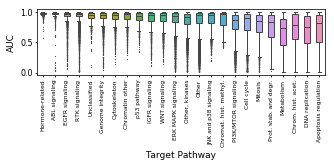

In [28]:
# Do the plotting 
# Establish order, i.e. sort by std in AUC
# order = list(response_df.groupby("TP abbr").agg({"AUC": np.std}).sort_values("AUC").index)
order = list(iqr_df["TP"])

ax = sns.boxplot(x="TP abbr", y="AUC", data=response_df,
                 order=order,
                linewidth=1.,
                fliersize=0.3,
                width=0.5)

ax.set_xlabel("Target Pathway")
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(fig_directory + "fig1_boxplot_auc_wrt_pathways.pdf")
plt.savefig(gimp_directory + "fig1_boxplot_auc_wrt_pathways.pdf")

plt.show()

In [18]:
tps = []
auc_stds = []

for tp in response_df["TARGET_PATHWAY"].unique():
    df = response_df[response_df["TARGET_PATHWAY"] == tp]
    std = df["AUC"].std()
    tps.append(tp)
    auc_stds.append(std)
std_df = pd.DataFrame()
std_df["TP"] = tps
std_df["STD"] = auc_stds

std_df.head()

,TP,STD
0,EGFR signaling,0.117231
1,PI3K/MTOR signaling,0.198026
2,RTK signaling,0.111132
3,Protein stability and degradation,0.215327
4,Mitosis,0.189350


In [20]:
std_df.sort_values("STD")

,TP,STD
12,Hormone-related,0.023231
22,p53 pathway,0.086734
20,Unclassified,0.089283
15,Cytoskeleton,0.094472
7,ABL signaling,0.096472
23,Chromatin other,0.103793
2,RTK signaling,0.111132
0,EGFR signaling,0.117231
13,Genome integrity,0.118541
21,Chromatin histone methylation,0.136121


#### Panel 4
Boxplots of obverall results across methods

In [31]:
# Set up constants

# Size in milimeters
panel_width_mm = 119.
panel_height_mm = 40.

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 119.0 4.685039370078741
Height: 40.0 1.5748031496062993


In [32]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[4.685039370078741, 1.5748031496062993]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [33]:
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

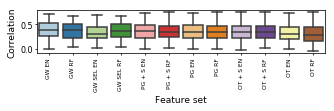

In [35]:
ax = sns.boxplot(x="Model", y="Model test correlation", data=df_agg_intersection,
                order=hue_order_all_models,
                palette=palette_all_models)

ax.set_xlabel("Feature set")
ax.set_ylabel("Correlation")

plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig(fig_directory + "fig1_boxplot_corr_across_models.pdf")
plt.savefig(gimp_directory + "fig1_boxplot_corr_across_models.pdf")

plt.show()

In [36]:
df_agg_intersection["Drug ID"].nunique()

175

## Figure 2

- Half page width: 85 mm
- Full page width: 170 mm
- 170 mm corresponds to 6.6929133858 inches
- One inch: 25.4 mm

4 panels

#### Panel 1
RMSE vs. correlation genome wide elastic net

In [13]:
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

In [14]:
# Constants for figure
mm_per_inch = 25.4
fig_width_in_mm = 170
fig_height_in_mm = 150

In [15]:
# Extract genome wide elastic net resuslts
df_gw_en = df_agg_all_models[df_agg_all_models.Model == "GW EN"]
print(df_gw_en.shape, df_gw_en["Model test correlation"].median())
df_gw_en.head(3)

(251, 9) 0.388596208358868


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
10,1,Erlotinib,0.071460,0.374202,0.004133,0.073378,1.017662,EGFR signaling,GW EN
14,3,Rapamycin,0.222320,0.269558,0.025780,0.229805,1.034771,PI3K/MTOR signaling,GW EN
30,5,Sunitinib,0.134001,0.419301,0.002418,0.138563,1.040323,RTK signaling,GW EN


In [76]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 50.
panel_height_mm = 50

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 10.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 50.0 1.968503937007874
Height: 50 1.968503937007874


In [77]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[1.968503937007874, 1.968503937007874]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


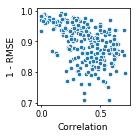

In [79]:
# Do the plotting 
ax = sns.scatterplot(x="Model test correlation", y=(1 - df_gw_en["Model test RMSE"]), data=df_gw_en,
                    s=20)
ax.set_xlabel("Correlation")
ax.set_ylabel("1 - RMSE")

plt.tight_layout()

plt.savefig(fig_directory + "fig2_rmse_vs_corr.pdf")
plt.savefig(gimp_directory + "fig2_rmse_vs_corr.pdf")

plt.show()

#### Panel 2
Relative test RMSE vs corr

In [25]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 56.
panel_height_mm = 50

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 10.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 56.0 2.204724409448819
Height: 50 1.968503937007874


In [26]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[2.204724409448819, 1.968503937007874]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


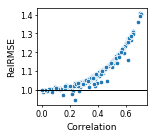

In [28]:
# Do the plotting 
ax = sns.scatterplot(x="Model test correlation", y="Relative test RMSE", data=df_gw_en,
                    s=20)
ax.set_xlabel("Correlation")
ax.set_ylabel("RelRMSE")

# Add a horizontal line at one
ax.axhline(y=1., color="black", linewidth=1.)

plt.tight_layout()

plt.savefig(fig_directory + "fig2_relrmse_vs_corr.pdf")
plt.savefig(gimp_directory + "fig2_relrmse_vs_corr.pdf")

plt.show()

#### Panel 3 
Correlation vs. std in AUC

In [80]:
# Load relevant drug IDs
with open("./Results and other files/drug_ids_to_keep_in_results.pkl", "rb") as f:
    relevant_drug_ids = dill.load(f)
print(len(relevant_drug_ids))

# Load relevant cell line IDs
with open("./Results and other files/set_of_all_analyzed_cell_lines.pkl", "rb") as f:
    relevant_cl_ids = dill.load(f)
print(type(relevant_cl_ids), len(relevant_cl_ids))

251
<class 'list'> 983


In [81]:
# Load dataframe with auc values
response_df = pd.read_csv("./Results and other files/drug_response_df_with_pathways.csv")
print(response_df.shape)
response_df = response_df[
    (response_df["DRUG_ID"].isin(relevant_drug_ids)) & (response_df["COSMIC_ID"].isin(relevant_cl_ids))
]
print(response_df.shape)
response_df.head(3)

(211457, 14)
(201166, 14)


,DATASET_VERSION,IC50_RESULTS_ID,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,MAX_CONC_MICROMOLAR,MIN_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,Z_SCORE,TARGET_PATHWAY
0,17.3,1,683665,MC-CAR,1,Erlotinib,EGFR,2.0,0.007812,2.453524,0.982610,0.021678,-0.015505,EGFR signaling
1,17.3,1482,684055,ES3,1,Erlotinib,EGFR,2.0,0.007812,3.376592,0.985169,0.029915,0.779999,EGFR signaling
2,17.3,1791,684057,ES5,1,Erlotinib,EGFR,2.0,0.007812,3.614664,0.983207,0.031201,0.985170,EGFR signaling


In [82]:
response_df.AUC.std()

0.1974860823377468

In [83]:
# Create a dictionary mapping from drug ID to it's AUC's standard deviation
dic = {}
for drug_id in relevant_drug_ids:
    df = response_df[response_df["DRUG_ID"] == drug_id]
    std = df["AUC"].std()
    dic[drug_id] = std
print(len(dic))

251


In [84]:
df_gw_en = df_agg_all_models[df_agg_all_models.Model == "GW EN"]

# Add column with STDs into enet genome wide df
df_gw_en["STD in AUC"] = df_gw_en["Drug ID"].map(dic)
print(df_gw_en.shape)
df_gw_en.head(3)

(251, 10)


/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,STD in AUC
10,1,Erlotinib,0.071460,0.374202,0.004133,0.073378,1.017662,EGFR signaling,GW EN,0.082368
14,3,Rapamycin,0.222320,0.269558,0.025780,0.229805,1.034771,PI3K/MTOR signaling,GW EN,0.231008
30,5,Sunitinib,0.134001,0.419301,0.002418,0.138563,1.040323,RTK signaling,GW EN,0.147625


In [85]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 50.
panel_height_mm = 50

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 10.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 50.0 1.968503937007874
Height: 50 1.968503937007874


In [86]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[1.968503937007874, 1.968503937007874]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


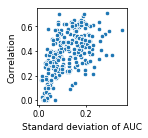

In [87]:
# Do the plotting
ax = sns.scatterplot(x="STD in AUC", y="Model test correlation", data=df_gw_en,
                    s=20)
ax.set_xlabel("Standard deviation of AUC")
ax.set_ylabel("Correlation")

plt.tight_layout()

plt.savefig(fig_directory + "fig2_stdAUC_vs_corr.pdf")
plt.savefig(gimp_directory + "fig2_stdAUC_vs_corr.pdf")

plt.show()

#### Panel 4 
RRMSE vs. correlation for best results

In [88]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 70.
panel_height_mm = 50

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 10.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False,
        'legend.fontsize': 4,
          'legend.handlelength': 2
}

Width: 70.0 2.7559055118110236
Height: 50 1.968503937007874


In [89]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

[2.7559055118110236, 1.968503937007874]
8.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [90]:
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

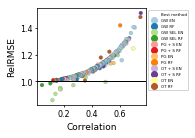

In [91]:
# Do the plotting
ax = sns.scatterplot(x="Model test correlation", y="Relative test RMSE", data=df_best_results,
                     hue="Corresponding experiment", 
                     hue_order=hue_order_all_models,
                     legend="brief",
                    s=15,
                    palette=palette_all_models,
                    linewidth=0.2,
                    edgecolor="gray",
                    alpha=1.)

ax.set_xlabel("Correlation")
ax.set_ylabel("RelRMSE")

legend = ax.legend(loc="upper left", bbox_to_anchor=(1,1))
legend.texts[0].set_text("Best method")

# Add a horizontal line at one
ax.axhline(y=1., color="black", linewidth=1.)
plt.tight_layout()

plt.savefig(fig_directory + "fig2_relrmse_vs_corr_best_models.pdf")
plt.savefig(gimp_directory + "fig2_stdAUC_vs_corr_best_models.pdf")


plt.show()

## Figure 3
Frequencies of models amon best, differences between model performance

3 panels

In [37]:
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

In [38]:
# Constants for figure
mm_per_inch = 25.4
fig_width_in_mm = 170
fig_height_in_mm = 50

#### Panel 1
Histogram of all models in best results - intersection of models

In [39]:
df_best_results_filtered_intersection = df_best_results_filtered[
    df_best_results_filtered["Drug ID"].isin(drug_intersection)
]
print(df_best_results_filtered.shape, df_best_results_filtered_intersection.shape)
df_best_results_filtered_intersection.head(3)

(232, 9) (162, 9)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling


In [40]:
counts = df_best_results_filtered_intersection["Corresponding experiment"].value_counts()
counts

GW EN        85
PG + S EN    12
GW RF        11
OT + S EN    10
GW SEL RF     9
PG EN         8
OT + S RF     7
PG + S RF     6
OT RF         5
PG RF         4
OT EN         3
GW SEL EN     2
Name: Corresponding experiment, dtype: int64

In [41]:
counts = df_best_results_filtered_intersection["Corresponding experiment"].value_counts()
df_agg = pd.DataFrame({"Model": counts.index, "Count": counts.values})
df_agg["Frequency"] = df_agg["Count"] / df_best_results_filtered_intersection.shape[0]
print(df_agg.shape)
df_agg.head()

(12, 3)


,Model,Count,Frequency
0,GW EN,85,0.524691
1,PG + S EN,12,0.074074
2,GW RF,11,0.067901
3,OT + S EN,10,0.061728
4,GW SEL RF,9,0.055556


In [42]:
# Set up constants

# Size in milimeters
panel_width_mm = 70.
panel_height_mm = 50.

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 11.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     ,
        'legend.fontsize': 6.,
        'legend.handlelength': 2}

Width: 70.0 2.7559055118110236
Height: 50.0 1.968503937007874


In [43]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[2.7559055118110236, 1.968503937007874]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [44]:
# Establish order and color palette
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

color_indexes = []
for mod in df_agg.Model:
    color_indexes.append(hue_order_all_models.index(mod))
print(color_indexes)
colors = [palette_all_models[i] for i in color_indexes]
order = df_agg.Model.unique()

[0, 4, 1, 8, 3, 6, 9, 5, 11, 7, 10, 2]


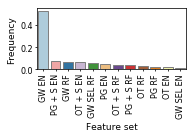

In [47]:
# Do the plotting
ax = sns.barplot(x="Model", y="Frequency", data=df_agg, order=order,
                palette=colors, edgecolor="grey")
ax.set_ylabel("Frequency")
ax.set_xlabel("Feature set")

plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig(fig_directory + "fig3_model_frequencies_among_best.pdf")
plt.savefig(gimp_directory + "fig3_model_frequencies_among_best.pdf")

plt.show()

In [48]:
df_agg

,Model,Count,Frequency
0,GW EN,85,0.524691
1,PG + S EN,12,0.074074
2,GW RF,11,0.067901
3,OT + S EN,10,0.061728
4,GW SEL RF,9,0.055556
5,PG EN,8,0.049383
6,OT + S RF,7,0.043210
7,PG + S RF,6,0.037037
8,OT RF,5,0.030864
9,PG RF,4,0.024691


#### Panel 2
Boxplot of differences between best and second best models

In [50]:
drug_intersection = df_best_results_filtered_intersection["Drug ID"].unique()
print(len(drug_intersection))

162


In [51]:
data = pd.read_csv("Results and other files/df_agg_all_drugs_restricted_vs_genome_wide.csv")
print(data.shape)
data = data[data["Drug ID"].isin(drug_intersection)]
print(data.shape)
data.head(6)

(2412, 9)
(1944, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.086347,0.388664,0.001450,0.092400,1.075011,EGFR signaling,Restricted
1,1,Erlotinib,0.086797,0.356010,0.000767,0.092400,1.062901,EGFR signaling,Restricted
2,1,Erlotinib,0.086307,0.375711,0.000364,0.092400,1.071611,EGFR signaling,Restricted
3,1,Erlotinib,0.087412,0.334809,0.003335,0.092400,1.059982,EGFR signaling,Restricted
4,1,Erlotinib,0.085563,0.391625,0.000803,0.092400,1.081329,EGFR signaling,Restricted
5,1,Erlotinib,0.097494,0.277307,0.027687,0.073378,0.765566,EGFR signaling,Genome-wide


In [52]:
# Get the differences
gw_best_diffs = []
restricted_best_diffs = []
s = 0

for drug_id in data["Drug ID"].unique():
    drug_df = data[data["Drug ID"] == drug_id]
    best_restricted = drug_df[drug_df.Model == "Restricted"].sort_values(
        "Model test correlation", ascending=False).iloc[0]["Model test correlation"]
    best_gw = drug_df[drug_df.Model == "Genome-wide"].sort_values(
        "Model test correlation", ascending=False).iloc[0]["Model test correlation"]
    
    if best_gw > best_restricted:
        gw_best_diffs.append(best_gw - best_restricted)
    else:
        restricted_best_diffs.append(best_restricted - best_gw)

print(len(gw_best_diffs), len(restricted_best_diffs))
df = pd.DataFrame()
mods = len(gw_best_diffs) * ["GW"] + len(restricted_best_diffs) * ["Restricted"]
df["Performance difference"] = gw_best_diffs + restricted_best_diffs
df["Better model"] = mods
print(df.shape)
df.head()

107 55
(162, 2)


,Performance difference,Better model
0,0.016300,GW
1,0.012402,GW
2,0.026216,GW
3,0.030440,GW
4,0.052152,GW


In [53]:
len(drug_intersection)

162

In [54]:
# Set up constants

# Size in milimeters
panel_width_mm = 60.
panel_height_mm = 50.

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 10.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     ,
        'legend.fontsize': 6.,
        'legend.handlelength': 2}

Width: 60.0 2.362204724409449
Height: 50.0 1.968503937007874


In [55]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[2.362204724409449, 1.968503937007874]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


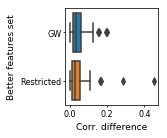

In [56]:
# Do the plotting
ax = sns.boxplot(y="Better model", x="Performance difference", data=df,
                orient="horizontal")

ax.set_xlabel("Corr. difference")
ax.set_ylabel("Better features set")

#plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig(fig_directory + "fig3_differences_boxplot.pdf")
plt.savefig(gimp_directory + "fig3_differences_boxplot.pdf")

plt.show()

In [57]:
df[df["Better model"] == "Restricted"]["Performance difference"].median()

0.0275937759676268

#### Panel 3
Best models but only between GW and GW with selection - rest of the intersection

In [49]:
# Create a DataFrame containing model counts from outside of drug intersection
df_best_results_rest = df_best_results_filtered[
    ~df_best_results_filtered["Drug ID"].isin(drug_intersection)
]
print(df_best_results_filtered.shape, df_best_results_rest.shape)
df_best_results_rest.head(3)

(232, 9) (70, 9)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
5,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
9,1242,(5Z)-7-Oxozeaenol,0.648544,4.310664e-30,1.299131,0.139781,0.181556,GW EN,"Other, kinases"
14,222,BX-912,0.635946,1.221257e-28,1.292786,0.129828,0.167987,GW EN,PI3K/MTOR signaling


In [50]:
counts = df_best_results_rest["Corresponding experiment"].value_counts()
df_agg = pd.DataFrame({"Model": counts.index, "Count": counts.values})
df_agg["Frequency"] = df_agg["Count"] / df_best_results_rest.shape[0]
print(df_agg.shape)
df_agg

(4, 3)


,Model,Count,Frequency
0,GW EN,48,0.685714
1,GW RF,18,0.257143
2,GW SEL RF,3,0.042857
3,GW SEL EN,1,0.014286


In [51]:
# Set up constants

# Size in milimeters
panel_width_mm = 40.
panel_height_mm = 50.

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     ,
        'legend.fontsize': 6.,
        'legend.handlelength': 2}

Width: 40.0 1.5748031496062993
Height: 50.0 1.968503937007874


In [52]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[1.5748031496062993, 1.968503937007874]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [53]:
# Establish order and color palette
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)
    
color_indexes = []
for mod in df_agg.Model:
    color_indexes.append(hue_order_all_models.index(mod))
print(color_indexes)
colors = [palette_all_models[i] for i in color_indexes]
order = df_agg.Model.unique()

[0, 1, 3, 2]


In [54]:
print(df_best_results_filtered.shape)
print(df_best_results_filtered["Drug ID"].nunique())

(232, 9)
232


In [55]:
mods = ["GW SEL EN", "GW SEL RF"]
df_best_results_filtered[
    df_best_results_filtered["Corresponding experiment"].isin(mods)
].shape

(15, 9)

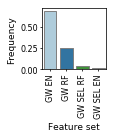

In [58]:
# Do the plotting
ax = sns.barplot(x="Model", y="Frequency", data=df_agg, order=order,
                edgecolor="grey", palette=colors)
ax.set_ylabel("Frequency")
ax.set_xlabel("Feature set")

plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig(fig_directory + "fig3_model_frequencies_not_intersection.pdf")
plt.savefig(gimp_directory + "fig3_model_frequencies_not_intersection.pdf")

plt.show()

## Figure 4
Boxplots of correlation grouped by pathways - restricted vs genome-wide models - filtered from bad drugs
- Half page width: 85 mm
- Full page width: 170 mm
- 170 mm corresponds to 6.6929133858 inches
- One inch: 25.4 mm

3 panels

In [66]:
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

In [67]:
# Constants for figure
mm_per_inch = 25.4
fig_width_in_mm = 170
fig_height_in_mm = 150

#### Panel 1
Results GW vs. rest grouped by pathways

In [68]:
print(df_best_results_from_two_groups_filtered.shape)
df_best_results_from_two_groups_filtered.head(3)

(324, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.085320,0.410257,0.000308,0.092400,1.086402,EGFR signaling,Restricted
1,1,Erlotinib,0.071460,0.374202,0.004133,0.073378,1.017662,EGFR signaling,Genome-wide
2,3,Rapamycin,0.223836,0.253258,0.042695,0.229805,1.027091,PI3K/MTOR signaling,Restricted


In [69]:
df_best_results_from_two_groups_filtered.sample(3)

,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
82,164,JQ12,0.162155,0.223663,2.981287e-03,0.165340,1.019711,Chromatin histone acetylation,Restricted
69,135,Gemcitabine,0.286602,0.410385,8.289701e-09,0.311460,1.087050,DNA replication,Genome-wide
245,1024,Lestaurtinib,0.159593,0.497076,7.100815e-17,0.183529,1.149920,"Other, kinases",Genome-wide


In [70]:
# Create a new DF with all pathways category (all results)
df_best_results_from_two_groups_filtered_with_all = df_best_results_from_two_groups_filtered.copy()
df_best_results_from_two_groups_filtered_with_all["Target Pathway"] = ["All pathways"] * \
    df_best_results_from_two_groups_filtered_with_all.shape[0]
print(df_best_results_from_two_groups_filtered_with_all.shape)
df_best_results_from_two_groups_filtered_with_all = pd.concat(
[df_best_results_from_two_groups_filtered, df_best_results_from_two_groups_filtered_with_all], axis=0)
print(df_best_results_from_two_groups_filtered_with_all.shape)
df_best_results_from_two_groups_filtered_with_all.head(3)

(324, 9)
(648, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.085320,0.410257,0.000308,0.092400,1.086402,EGFR signaling,Restricted
1,1,Erlotinib,0.071460,0.374202,0.004133,0.073378,1.017662,EGFR signaling,Genome-wide
2,3,Rapamycin,0.223836,0.253258,0.042695,0.229805,1.027091,PI3K/MTOR signaling,Restricted


In [71]:
from scipy.stats import mannwhitneyu

def stars(p):
    if p < 0.0001:
       return "****"
    elif (p < 0.001):
       return "***"
    elif (p < 0.01):
       return "**"
    elif (p < 0.05):
       return "*"
    else:
       return "ns"

# Initialize dictionary with target pathways and corresponding significance tests
significance_dict = {}

for tp in df_best_results_from_two_groups_filtered_with_all["Target Pathway"].unique():
    df = df_best_results_from_two_groups_filtered_with_all[
        df_best_results_from_two_groups_filtered_with_all["Target Pathway"] == tp
    ]
    x = df[df.Model == "Genome-wide"]["Model test correlation"]
    y = df[df.Model == "Restricted"]["Model test correlation"]
    
    p = mannwhitneyu(x, y)[1] * 2
    
    significance_dict[tp] = p
print(len(significance_dict))

25


In [72]:
# Set up constants

# Size in milimeters
panel_width_mm = 170.
panel_height_mm = 95.

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     ,
        'legend.fontsize': 6.,
        'legend.handlelength': 2}

Width: 170.0 6.692913385826772
Height: 95.0 3.7401574803149606


In [73]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[6.692913385826772, 3.7401574803149606]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


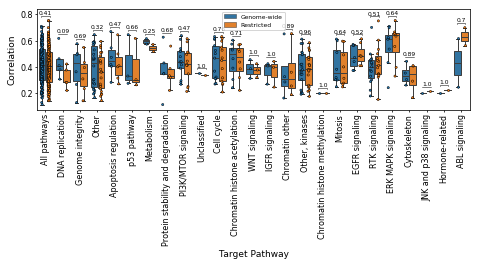

In [298]:
# Establish order of the pathways
differences = []

for tp in df_best_results_from_two_groups_filtered["Target Pathway"].unique():
    df = df_best_results_from_two_groups_filtered[
        df_best_results_from_two_groups_filtered["Target Pathway"] == tp
    ]
    df = df.groupby("Model", as_index=False).agg(np.median)
    gw_corr = df[df.Model == "Genome-wide"]["Model test correlation"].iloc[0]
    restricted_corr = df[df.Model == "Restricted"]["Model test correlation"].iloc[0]
    diff = gw_corr - restricted_corr
    differences.append((tp, diff / gw_corr))

differences = sorted(differences, key=lambda x: x[1], reverse=True)
order = ["All pathways"] + [x[0] for x in differences]

############################################
# Actual plotting
############################################

ax = sns.boxplot(x="Target Pathway", y="Model test correlation", 
                   data=df_best_results_from_two_groups_filtered_with_all,
                 hue="Model",
                 linewidth=1.,
                 fliersize=0.0,
                 dodge=True,
                 order=order,
                 hue_order = ["Genome-wide", "Restricted"])

sns.stripplot(x="Target Pathway", y="Model test correlation", 
                   data=df_best_results_from_two_groups_filtered_with_all,
                   hue="Model",
                   dodge=True,
                   linewidth=0.5,
                   jitter=True,
                   edgecolor="black",
                   size=2.2,
                   order=order,
                   hue_order = ["Genome-wide", "Restricted"],
                   ax=ax)

##############################################################
# Add significance asterixes
##############################################################

# Constants
vertical_length = 0.005
horizontal_length = 0.5
y_margin = 0.03
linewidth = 0.5
col = "black"
text_color = "black"
text_size = 6

# Determine x and y coordinates

for i in range(len(order)):
    # Determine x and y coordinates
    xs = []
    ys = []
    
    x = ax.get_xticks()[i]
    xs.append(x - horizontal_length / 2)
    xs.append(x - horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    
    tp = order[i]
    
    # Get y data
    df = df_best_results_from_two_groups_filtered_with_all[
        df_best_results_from_two_groups_filtered_with_all["Target Pathway"] == tp
    ]
    
    ymax = df["Model test correlation"].max()
    ys.append(ymax + y_margin)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin)
    
    ax.plot(xs, ys, lw=linewidth, c=col)
    ax.text(x+0.01, ymax + y_margin + vertical_length, round(significance_dict[tp], 2), 
           ha="center", va="bottom", color=text_color, fontsize=text_size)



# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Correlation")
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.02)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],
#               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)

l = plt.legend(handles[0:2], labels[0:2], loc="best")

plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig(fig_directory + "fig3_boxplot_corr_wrt_pathways.pdf")
plt.savefig(gimp_directory + "fig3_boxplot_corr_wrt_pathways.pdf")

plt.show()

#### Panel 1, version 2 - not just one best from GW and restricted per drug, but all models

In [89]:
# Load DataFrame with aggregated results for all drugs, with models classified to two groups
df_restricted_vs_gw = pd.read_csv("./Results and other files/df_agg_all_drugs_restricted_vs_genome_wide.csv")
print(df_restricted_vs_gw.shape, df_restricted_vs_gw["Drug ID"].nunique(), df_restricted_vs_gw["Model"].nunique())
df_restricted_vs_gw_filtered = df_restricted_vs_gw[~df_restricted_vs_gw["Drug ID"].isin(bad_drugs)]
print(df_restricted_vs_gw_filtered["Drug ID"].nunique())
df_restricted_vs_gw_filtered.sample(5)

(2412, 9) 251 2
232


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
1113,273,CUDC-101,0.192363,0.393991,3.106236e-07,0.209310,1.089173,Other,Restricted
2233,1241,CHIR-99021,0.053065,0.423900,2.590431e-11,0.058173,1.096032,WNT signaling,Restricted
2050,1142,HG-5-113-01,0.094895,0.400891,2.154029e-06,0.101792,1.072923,Other,Genome-wide
293,71,Pyrimethamine,0.114826,0.240857,2.187409e-02,0.117322,1.022030,Other,Genome-wide
739,199,Pazopanib,0.096263,0.264070,2.879737e-04,0.098636,1.023808,RTK signaling,Genome-wide


In [90]:
# Find drugs only modeled by genome-wide methods
drugs_only_modeled_by_gw = []
for drug_id in df_restricted_vs_gw["Drug ID"].unique():
    df = df_restricted_vs_gw[df_restricted_vs_gw["Drug ID"] == drug_id]
    if df.shape[0] == 4:
        drugs_only_modeled_by_gw.append(drug_id)
print(len(drugs_only_modeled_by_gw))

74


In [91]:
# Compute results at intersection
df_restricted_vs_gw_filtered_intersection = df_restricted_vs_gw_filtered[
    ~df_restricted_vs_gw_filtered["Drug ID"].isin(drugs_only_modeled_by_gw)
]
print(df_restricted_vs_gw_filtered_intersection["Drug ID"].nunique())

164


In [92]:
# Establish dataset to plot
data = df_restricted_vs_gw_filtered_intersection
print(data["Drug ID"].nunique())

164


In [93]:
# Set up constants

# Size in milimeters
panel_width_mm = 165.
panel_height_mm = 70.

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     ,
        'legend.fontsize': 6.,
        'legend.handlelength': 2}

Width: 165.0 6.496062992125984
Height: 70.0 2.7559055118110236


In [94]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[6.496062992125984, 2.7559055118110236]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [95]:
# Load dictionary with target pathways names abbrevations
with open("./Results and other files/tp_names_abbrevations.pkl", "rb") as f:
    tp_abbrevations = dill.load(f)
print(len(tp_abbrevations))
# Add column with TP abrrevations to data
data["TP abbr"] = data["Target Pathway"].map(tp_abbrevations)

24


/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [96]:
# Perform tests
from scipy.stats import mannwhitneyu

def stars(p):
    if p < 0.0001:
       return "****"
    elif (p < 0.001):
       return "***"
    elif (p < 0.01):
       return "**"
    elif (p < 0.05):
       return "*"
    else:
       return "ns"

# Initialize dictionary with target pathways and corresponding significance tests
significance_dict = {}

for tp in data["TP abbr"].unique():
    df = data[
        data["TP abbr"] == tp
    ]
    x = df[df.Model == "Genome-wide"]["Model test correlation"]
    y = df[df.Model == "Restricted"]["Model test correlation"]
    
    p = mannwhitneyu(x, y)[1]
    print(tp, x.shape, y.shape, p)
    
    significance_dict[tp] = p
print(len(significance_dict))

EGFR signaling (28,) (56,) 0.1607030839165891
PI3K/MTOR signaling (52,) (104,) 0.09380513026167747
RTK signaling (60,) (120,) 0.2488200557187913
Prot. stab. and degr. (20,) (40,) 0.4039796935907516
Mitosis (32,) (64,) 0.12906033734276717
Other (92,) (180,) 0.021302511304851383
ERK MAPK signaling (32,) (64,) 0.4891491357179047
ABL signaling (8,) (16,) 0.22199718801150475
Cell cycle (52,) (104,) 0.1790002986654879
Other, kinases (84,) (168,) 0.1024464141630021
Chrom. hist. acet. (32,) (64,) 0.33310588102256267
DNA replication (24,) (44,) 1.1108256989329505e-05
Hormone-related (4,) (8,) 0.025399260369419956
Genome integrity (24,) (48,) 0.08383938271579178
Apoptosis regulation (24,) (48,) 0.04109970433892837
Cytoskeleton (16,) (32,) 0.19382620871642836
IGFR signaling (12,) (24,) 0.40064284781343484
p53 pathway (12,) (24,) 0.26735924476394995
Chromatin other (16,) (32,) 0.35910118321361284
Metabolism (8,) (16,) 0.0022029844239215956
WNT signaling (12,) (24,) 0.13771817209143739
JNK and p38 

In [97]:
s = 0
for tp in data["TP abbr"].unique():
    df = data[
        data["TP abbr"] == tp
    ]
    x = df[df.Model == "Genome-wide"]["Model test correlation"]
    y = df[df.Model == "Restricted"]["Model test correlation"]
    
    print(tp, x.median() - y.median())
    if x.median() > y.median():
        s += 1
        
print()
print(s)

EGFR signaling -0.01807249063469968
PI3K/MTOR signaling 0.013140125993350127
RTK signaling -0.0051550557496462535
Prot. stab. and degr. -0.0015230941998035652
Mitosis 0.008542093735053324
Other 0.048001064757790146
ERK MAPK signaling 0.007563660643866821
ABL signaling -0.06955471075807851
Cell cycle 0.03624676413445471
Other, kinases 0.028639668743989988
Chrom. hist. acet. 0.01630097608834019
DNA replication 0.13516248538567754
Hormone-related -0.04042731253094539
Genome integrity 0.09069750372888463
Apoptosis regulation 0.03880211554346147
Cytoskeleton 0.008817844884931092
IGFR signaling -0.02361400689268761
p53 pathway 0.012977970176463127
Chromatin other -0.02844999943066273
Metabolism 0.06340795144920075
WNT signaling 0.020491014194358004
JNK and p38 signaling -0.061229789513089966
Unclassified 0.00726101289689568
Chromat. hist. methyl. -0.006053546928627279

15


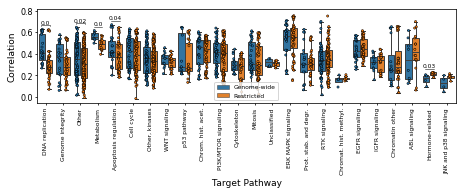

In [98]:
# Establish order of the pathways
differences = []

for tp in data["TP abbr"].unique():
    df = data[
        data["TP abbr"] == tp
    ]
    df = df.groupby("Model", as_index=False).agg(np.median)
    gw_corr = df[df.Model == "Genome-wide"]["Model test correlation"].iloc[0]
    restricted_corr = df[df.Model == "Restricted"]["Model test correlation"].iloc[0]
    diff = gw_corr - restricted_corr
    differences.append((tp, diff / gw_corr))

differences = sorted(differences, key=lambda x: x[1], reverse=True)
order = [x[0] for x in differences]

############################################
# Actual plotting
############################################

#plt.figure(figsize=(12, 8))

ax = sns.boxplot(x="TP abbr", y="Model test correlation", 
                   data=data,
                 hue="Model",
                 linewidth=1.,
                 fliersize=0.0,
                 dodge=True,
                 order=order,
                 hue_order = ["Genome-wide", "Restricted"])

sns.stripplot(x="TP abbr", y="Model test correlation", 
                   data=data,
                   hue="Model",
                   dodge=True,
                   linewidth=0.5,
                   jitter=True,
                   edgecolor="black",
                   size=2.2,
                   order=order,
                   hue_order = ["Genome-wide", "Restricted"],
                   ax=ax)

##############################################################
# Add significance asterixes
##############################################################

# Constants
vertical_length = 0.005
horizontal_length = 0.5
y_margin = 0.03
linewidth = 0.5
col = "black"
text_color = "black"
text_size = 6

# Determine x and y coordinates

for i in range(len(order)):
    # Determine x and y coordinates
    xs = []
    ys = []
    
    x = ax.get_xticks()[i]
    xs.append(x - horizontal_length / 2)
    xs.append(x - horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    
    tp = order[i]
    
    # Get y data
    df = data[
        data["Target Pathway"] == tp
    ]
    
    ymax = df["Model test correlation"].max()
    ys.append(ymax + y_margin)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin)
    
    if significance_dict[tp] < 0.05:
    
        ax.plot(xs, ys, lw=linewidth, c=col)
        ax.text(x+0.01, ymax + y_margin + vertical_length, round(significance_dict[tp], 2), 
               ha="center", va="bottom", color=text_color, fontsize=text_size)



# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Correlation")
ax.set_xlabel("Target Pathway")

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.02)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],
#               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)

l = plt.legend(handles[0:2], labels[0:2], loc="lower center")

plt.xticks(rotation=90)


#plt.grid()
plt.tight_layout()

plt.savefig(fig_directory + "fig4_boxplot_corr_wrt_pathways_all_models.pdf")
plt.savefig(gimp_directory + "fig4_boxplot_corr_wrt_pathways_all_models.pdf")

plt.show()

In [99]:
mapper = {"Genome-wide": "Genome-wide", "Restricted": "Biologically driven"}
data["Model"] = data["Model"].map(mapper)

/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


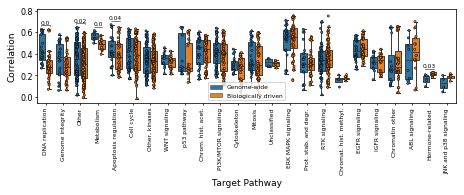

In [100]:
# Establish order of the pathways
differences = []

for tp in data["TP abbr"].unique():
    df = data[
        data["TP abbr"] == tp
    ]
    df = df.groupby("Model", as_index=False).agg(np.median)
    gw_corr = df[df.Model == "Genome-wide"]["Model test correlation"].iloc[0]
    restricted_corr = df[df.Model == "Biologically driven"]["Model test correlation"].iloc[0]
    diff = gw_corr - restricted_corr
    differences.append((tp, diff / gw_corr))

differences = sorted(differences, key=lambda x: x[1], reverse=True)
order = [x[0] for x in differences]

############################################
# Actual plotting
############################################

#plt.figure(figsize=(12, 8))

ax = sns.boxplot(x="TP abbr", y="Model test correlation", 
                   data=data,
                 hue="Model",
                 linewidth=1.,
                 fliersize=0.0,
                 dodge=True,
                 order=order,
                 hue_order = ["Genome-wide", "Biologically driven"])

sns.stripplot(x="TP abbr", y="Model test correlation", 
                   data=data,
                   hue="Model",
                   dodge=True,
                   linewidth=0.5,
                   jitter=True,
                   edgecolor="black",
                   size=2.2,
                   order=order,
                   hue_order = ["Genome-wide", "Biologically driven"],
                   ax=ax)

##############################################################
# Add significance asterixes
##############################################################

# Constants
vertical_length = 0.005
horizontal_length = 0.5
y_margin = 0.03
linewidth = 0.5
col = "black"
text_color = "black"
text_size = 6

# Determine x and y coordinates

for i in range(len(order)):
    # Determine x and y coordinates
    xs = []
    ys = []
    
    x = ax.get_xticks()[i]
    xs.append(x - horizontal_length / 2)
    xs.append(x - horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    
    tp = order[i]
    
    # Get y data
    df = data[
        data["Target Pathway"] == tp
    ]
    
    ymax = df["Model test correlation"].max()
    ys.append(ymax + y_margin)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin)
    
    if significance_dict[tp] < 0.05:
    
        ax.plot(xs, ys, lw=linewidth, c=col)
        ax.text(x+0.01, ymax + y_margin + vertical_length, round(significance_dict[tp], 2), 
               ha="center", va="bottom", color=text_color, fontsize=text_size)



# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Correlation")
ax.set_xlabel("Target Pathway")

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.02)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],
#               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)

l = plt.legend(handles[0:2], labels[0:2], loc="lower center")

plt.xticks(rotation=90)


#plt.grid()
plt.tight_layout()

plt.savefig(fig_directory + "fig4_boxplot_corr_wrt_pathways_all_models.pdf")
plt.savefig(gimp_directory + "fig4_boxplot_corr_wrt_pathways_all_models.pdf")

plt.show()

#### Panel 2
Results from all methods per drug for DNA replication pathway

In [25]:
df_dna_rep_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Target Pathway"] == "DNA replication"]
print(df_dna_rep_all_models.shape, df_dna_rep_all_models["Drug ID"].nunique())

(91, 9) 11


In [40]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 140.
panel_height_mm = 50.

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 10.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False,
        'legend.fontsize': 6,
          'legend.handlelength': 2
}

Width: 140.0 5.511811023622047
Height: 50.0 1.968503937007874


In [41]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[5.511811023622047, 1.968503937007874]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [42]:
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

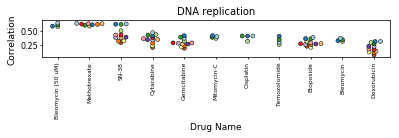

In [43]:
# Plot drugs in DNA replication pathway
#plt.figure(figsize=(10, 6))

order = df_dna_rep_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_dna_rep_all_models,
                  hue="Model",
                  order=order,
                  hue_order = hue_order_all_models,
                  palette=palette_all_models,
                  size=4.,
                  linewidth=0.5,
                  dodge=False,
                  alpha=1.,
                  edgecolor="black")

ax.set_title("DNA replication")
ax.set_xlabel("Drug Name")
ax.set_ylabel("Correlation")

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i in range(12):
    l.legendHandles[i].set_sizes([20])

plt.xticks(rotation=90)
#plt.grid()
ax.get_legend().remove()
plt.tight_layout()

plt.savefig(fig_directory + "fig4_dna_replication.pdf")
plt.savefig(gimp_directory + "fig4_dna_replication.pdf")

plt.show()

#### Panel 3
Results from all methods per drug for RTK signaling pathway

In [30]:
df_rtk_sign_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Target Pathway"] == "RTK signaling"
]
print(df_rtk_sign_all_models.shape, df_rtk_sign_all_models["Drug ID"].nunique())

(195, 9) 18


In [36]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 140.
panel_height_mm = 50.

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 10.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False,
        'legend.fontsize': 6,
          'legend.handlelength': 2
}

Width: 140.0 5.511811023622047
Height: 50.0 1.968503937007874


In [37]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[5.511811023622047, 1.968503937007874]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [38]:
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

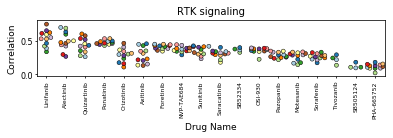

In [39]:
# Plot drugs in DNA replication pathway
#plt.figure(figsize=(10, 6))

order = df_rtk_sign_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_rtk_sign_all_models,
                  hue="Model",
                  order=order,
                  hue_order = hue_order_all_models,
                  palette=palette_all_models,
                  size=4.,
                  linewidth=0.5,
                  dodge=False,
                  alpha=1.,
                  edgecolor="black")

ax.set_title("RTK signaling")
ax.set_xlabel("Drug Name")
ax.set_ylabel("Correlation")

l = plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
for i in range(12):
    l.legendHandles[i].set_sizes([20])

# ax.get_legend().set_visible(False)

plt.xticks(rotation=90)
#plt.grid()
ax.get_legend().remove()

plt.tight_layout()

plt.savefig(fig_directory + "fig4_rtk_signaling.pdf")
plt.savefig(gimp_directory + "fig4_rtk_signaling.pdf")

plt.show()

## Figure 5
Feature importances

In [88]:
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

#### Panel 1 - feature importances

In [44]:
df_best_from_restricted = pd.read_csv("Results and other files/df_best_results_per_drug_from_restricted_models.csv")
print(df_best_from_restricted.shape, df_best_from_restricted["Drug ID"].nunique())
df_best_from_restricted.head(3)

(177, 9) 177


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1373,Dabrafenib,0.127750,0.752645,1.075014e-40,0.193280,1.514006,ERK MAPK signaling,OT + S RF
1,277,Linifanib,0.055801,0.749668,4.346970e-19,0.080856,1.483354,RTK signaling,OT RF
2,52,GNF-2,0.043907,0.698448,2.000000e-01,0.053700,1.246686,ABL signaling,OT EN


In [45]:
with open("Results and other files/feature_importances_all_restricted_modelings.pkl", "rb") as f:
    feat_imps_all_restricted_mods = dill.load(f)
print(len(feat_imps_all_restricted_mods))

177


In [50]:
# Extract data for restricted models with signatures
data_signature_models = df_agg_all_models[
    df_agg_all_models.Model.isin(["OT + S EN", "OT + S RF", "PG + S EN", "PG + S RF"])
]
print(data_signature_models.shape, data_signature_models.Model.nunique())

(704, 9) 4


In [51]:
# Create a dict containing information about models consisting all feature types
models_with_all_feats = {}
sign_mods = ["OT + S EN", "OT + S RF", "PG + S EN", "PG + S RF"]


for name, ide in feat_imps_all_restricted_mods:
    models_with_all = []
    for model in sign_mods:
        if model in feat_imps_all_restricted_mods[(name, ide)]:
            feat_names = [x[0] for x in feat_imps_all_restricted_mods[(name, ide)][model].importances_vector]
            corr = feat_imps_all_restricted_mods[(name, ide)][model].test_correlation
            feat_types = ModelingResults.check_feature_types(feat_names)
            if len(feat_types) == 5:
                models_with_all.append((model, corr))
                
    if len(models_with_all) > 0:
        models_with_all = sorted(models_with_all, key=lambda x: x[1], reverse=True)
        models_with_all_feats[(name, ide)] = models_with_all
        
print("All drugs with restricted models:", len(feat_imps_all_restricted_mods))
print("Drugs with at least one restricted model with all feature types:", len(models_with_all_feats))
print(models_with_all_feats[("Erlotinib", 1)])

All drugs with restricted models: 177
Drugs with at least one restricted model with all feature types: 160
[('OT + S EN', 0.4102571189894932), ('PG + S RF', 0.3916252656462129), ('PG + S EN', 0.3757112401003099), ('OT + S RF', 0.33480861356789704)]


In [52]:
# Make sort drugs with models with all feature types by correlation
ides = []
names = []
models = []
corrs = []

for name, ide in models_with_all_feats:
    ides.append(ide)
    names.append(name)
    models.append(models_with_all_feats[(name, ide)][0][0])
    corrs.append(models_with_all_feats[(name, ide)][0][1])
    
df = pd.DataFrame()
df["Drug ID"] = ides
df["Drug Name"] = names
df["Model"] = models
df["Test correlation"] = corrs

df = df.sort_values("Test correlation", ascending=False).reset_index(drop=True)
print(df.shape)
df.head(3)

(160, 4)


,Drug ID,Drug Name,Model,Test correlation
0,1373,Dabrafenib,OT + S RF,0.752645
1,29,AZ628,OT + S EN,0.665869
2,1372,Trametinib,PG + S EN,0.653570


In [53]:
# Extract feature information about feature importance for top 50 drugs, 
# using only models with all feature types
k = 50
topk_feats = 2
top_feature_types = {"tissue": 0,
                    "expression": 0,
                    "mutation": 0,
                    "signatures": 0,
                    "CNV": 0}
for idx, row in df.iloc[:50].iterrows():
    ide = row["Drug ID"]
    name = row["Drug Name"]
    best_model = row["Model"]
    
    top_feats = feat_imps_all_restricted_mods[(name, ide)][best_model].importances_vector[:topk_feats]
    top_feats = [x[0] for x in top_feats]
   
    for feat_type in top_feature_types:
        top_feature_types[feat_type] += ModelingResults.count_feat_types(top_feats, feat_type)
        
        
print("Last correlation:", df.iloc[k-1]["Test correlation"])
print("Top mutations:", top_feature_types["mutation"])
print("Top expressions", top_feature_types["expression"])
print("Top signatures", top_feature_types["signatures"])
print("Top tissue", top_feature_types["tissue"])
print("Top CNV", top_feature_types["CNV"])

Last correlation: 0.4693335618103786
Top mutations: 6
Top expressions 45
Top signatures 34
Top tissue 14
Top CNV 1


In [80]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 170.
panel_height_mm = 50.

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 8.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False,
        'legend.fontsize': 6,
          'legend.handlelength': 2
}

Width: 170.0 6.692913385826772
Height: 50.0 1.968503937007874


In [81]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[6.692913385826772, 1.968503937007874]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


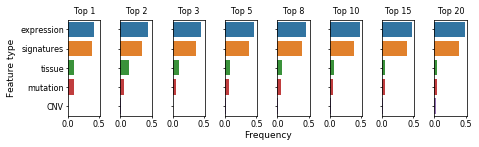

In [101]:
# Plot the counts / frequencies
order = ["expression", "signatures", "tissue", "mutation", "CNV"]

fig = plt.figure()

kfeats = [1, 2, 3, 5, 8, 10, 15, 20]
kdrugs = 50
i = 1

for kfeat in kfeats:
    topk_feats = kfeat
    top_feature_types = {"tissue": 0,
                        "expression": 0,
                        "mutation": 0,
                        "signatures": 0,
                        "CNV": 0}
    for idx, row in df.iloc[:kdrugs].iterrows():
        ide = row["Drug ID"]
        name = row["Drug Name"]
        best_model = row["Model"]

        top_feats = feat_imps_all_restricted_mods[(name, ide)][best_model].importances_vector[:topk_feats]
        top_feats = [x[0] for x in top_feats]

        for feat_type in top_feature_types:
            top_feature_types[feat_type] += ModelingResults.count_feat_types(top_feats, feat_type)
            
    xs = []
    ys = []
    
    for feat in top_feature_types:
        xs.append(feat)
        ys.append(top_feature_types[feat] / (kfeat * kdrugs))
        
    ax = fig.add_subplot(1, len(kfeats), i)
    sns.barplot(x=ys, y=xs, order=order, orient="h", ax=ax)
    ax.set_title("Top {}".format(kfeat))
    ax.set_xlim((0.0, 0.51345))
    if i != 1:
        ax.set_yticklabels(["" for x in range(len(ax.get_yticklabels()))])
    if i == 1:
        ax.set_ylabel("Feature type")
    
    i += 1
    
    
fig.text(0.56, 0.00, 'Frequency', ha="center", va="bottom", fontsize=9)
#sns.despine(left=True, bottom=True)
plt.tight_layout()
fig.subplots_adjust(bottom=0.17) # or whatever

plt.savefig(fig_directory + "fig5_feat_importances.pdf")
plt.savefig(gimp_directory + "fig5_feat_importances.pdf")

plt.show()

## Figure 6
Drugs of interest
- Half page width: 85 mm
- Full page width: 170 mm
- 170 mm corresponds to 6.6929133858 inches
- One inch: 25.4 mm

One panel with drug summary and scatter plots

In [30]:
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

In [92]:
# Load DataFrame with drugs of interest
df_doi = pd.read_csv("./Results and other files/drugs_of_interest.csv")
print(df_doi.shape)

(10, 10)


#### Panel 1
Drugs of interest results for all models

In [23]:
# Load DataFrame with drugs of interest
df_doi = pd.read_csv("./Results and other files/drugs_of_interest.csv")
print(df_doi.shape)

(10, 10)


In [24]:
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

In [25]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 170.
panel_height_mm = 100.

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False,
        'legend.fontsize': 6,
          'legend.handlelength': 2
}

Width: 170.0 6.692913385826772
Height: 100.0 3.937007874015748


In [26]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[6.692913385826772, 3.937007874015748]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


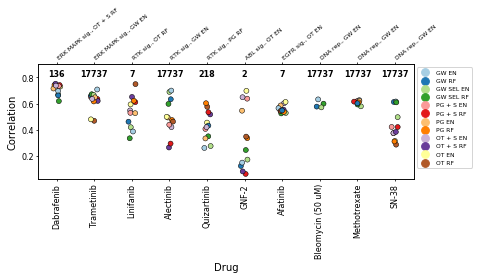

In [31]:
# Plot the DOIs for all models
#plt.figure(figsize=(10, 4))

# Extract drugs of interest from overall DF
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug ID"].isin(df_doi["Drug ID"].unique())
]

df = df[df.Model != "GW AF EN"]

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order_all_models,
                  order = df_doi["Drug Name"].unique(), 
                  palette=palette_all_models,
                  size=5,
                  linewidth=0.5,
                  jitter=True,
                  dodge=False,
                  edgecolor="black")

ax.set_xlabel("Drug", fontsize=10)
ax.set_ylabel("Correlation", fontsize=10)
ax.tick_params(axis='x', labelsize=8, rotation=90)
ax.tick_params(axis='y', labelsize=8)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.1)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
labels = []
for tp, mod in zip(df_doi["Target Pathway"].values, df_doi["Model"].values):
    if tp == "ERK MAPK signaling":
        tp = "ERK MAPK sig."
    elif tp =="RTK signaling":
        tp = "RTK sig."
    elif tp == "ABL signaling":
        tp = "ABL sig."
    elif tp == "EGFR signaling":
        tp = "EGFR sig."
    elif tp == "DNA replication":
        tp = "DNA rep."
    labels.append(tp + ", " + mod)

ax2.set_xticklabels(labels, rotation=40, ha="left")

# Add feature numbers
vertical_position = 0.79
text_color = "black"
text_size = 8

#plt.grid()

for i in range(df_doi.shape[0]):
    feat_number = int(df_doi["No. features"].iloc[i])
    if feat_number == 17737:
        pass
    # Determine x and y coordinates
    x = ax.get_xticks()[i]
    ax.text(x, vertical_position, feat_number, ha="center", va="bottom", color=text_color, fontsize=text_size,
           fontweight="bold")


l = ax.legend(loc="upper left", bbox_to_anchor=(1,1))

#plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig(fig_directory + "fig6_doi.pdf")
plt.savefig(gimp_directory + "fig6_doi.pdf")
plt.tight_layout()

plt.show()

# Figure 7
Scatter plots and feature importances for DOI

In [101]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

In [102]:
# Set the directory to save figures (panels) in
fig_directory = "./Figures for article working version/"
gimp_directory = "/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Moje artykuły/Modeling drug efficacy/Figures/Panels/"

In [103]:
# Load DataFrame with drugs of interest
df_doi = pd.read_csv("./Results and other files/drugs_of_interest.csv")
print(df_doi.shape)

(10, 10)


In [104]:
# Load genome-wide ENet ModelingResult object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "genome_wide-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
    genome_wide_without_selection_enet = dill.load(f)
print(type(genome_wide_without_selection_enet), 
      len(genome_wide_without_selection_enet.feat_importances_dict))

<class 'gdsc_projects_module.ModelingResults'> 10


#### Panel 1 - scatter plot of a given drug

In [67]:
# Load corresponding best ModelingResults object
# Set directory with results
model_name = "OT RF + S"
filepath = "./Final experimental raw results/"
with open(filepath + "only_targets-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)
print(len(restricted_results.performance_dict))

Only targets - modeling with RForest over few data splits
184


In [113]:
# Pick a split to work on
drug_name = "Dabrafenib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)
split_seed = 98  #37

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [114]:
# Perform both modelings
# Generate full data for both models - genome-wide all features
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs

# drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
#                                        map_target_genes_to_same_pathways_genes)

drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)

drug_restricted = drugs[drug_tuple[1]]

del drugs


# Create full data for GW model
data_types = ["expression"]
data_gw = drug_gw.create_full_data(drug_response_df, data_combination=data_types, 
                                 gene_expression_df=gene_expression_df, 
                                 cnv_binary_df=cnv_binary_df,
                                 map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                 cell_line_list=cell_lines_list_df,
                                 mutation_df=coding_variants_df,
                                 merck_signatures_df=signatures_df)
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue", "merck signatures"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df,
                                     merck_signatures_df=signatures_df)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)

print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/gdsc_projects_module.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  obj.sort_values("cell_line_id", inplace=True)


Shape of created GW data: (875, 17739)
Shape of created restricted data: (823, 150)
X_train_gw and X_train_restricted shape: (576, 17737) (576, 148)
X_test_gw and X_test_restricted shape: (247, 17737) (247, 148)
y_both_train and y_both_test shape: (576,) (247,)
219.30321399999997


In [115]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.1, 'estimator__alpha': 0.1}
Test correlation: (0.7062171651853143, 1.2991658637429642e-38)
Test RMSE: 0.1321754129566954


In [116]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

# Setup estimator
estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__n_estimators': 50, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 10, 'estimator__criterion': 'mse'}
Test correlation: (0.7319756779857627, 1.0318492008604856e-42)
Test RMSE: 0.13115409618655435


In [117]:
# Load hue order for all models and corresponding color palette
with open("./Results and other files/hue_order_all_models.pkl", "rb") as f:
    hue_order_all_models = dill.load(f)
with open("./Results and other files/palette_all_models.pkl", "rb") as f:
    palette_all_models = dill.load(f)

In [118]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 55.
panel_height_mm = 50.

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False,
        'legend.fontsize': 6,
          'legend.handlelength': 2
}

Width: 55.0 2.1653543307086616
Height: 50.0 1.968503937007874


In [119]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[2.1653543307086616, 1.968503937007874]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


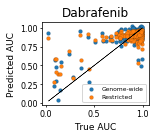

In [120]:
# Plot predicted vs. actual AUC for both models
ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=15, label="Genome-wide", linewidth=0.1, 
                    edgecolor="black")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=15, label = "Restricted", linewidth=0.1, 
                    edgecolor="black")

ax.plot(y_test_both, y_test_both, color="black", linewidth=0.5)

ax.set_title(drug_tuple[0], fontsize=12)
ax.set_xlabel("True AUC")
ax.set_ylabel("Predicted AUC")

plt.tight_layout()

# plt.savefig(fig_directory + "fig7_scatter_plot_" + drug_tuple[0] + ".pdf")
# plt.savefig(gimp_directory + "fig7_scatter_plot_" + drug_tuple[0] + ".pdf")

plt.show()

#### Panel 2 - feature importances for restricted model

In [117]:
# Set up constants
# width of the page: 6.69
mm_per_inch = 25.4

panel_width_mm = 55.
panel_height_mm = 60.

panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 8      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 9.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 300.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False,
        'legend.fontsize': 6,
          'legend.handlelength': 2
}

Width: 55.0 2.1653543307086616
Height: 60.0 2.362204724409449


In [118]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))
print(plt.rcParams.get('legend.fontsize'))

[2.1653543307086616, 2.362204724409449]
8.0
6.0


/home/krzysztof/.local/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [124]:
# Load corresponding best ModelingResults object
# Set directory with results
model_name = "PG RF"
filepath = "./Final experimental raw results/"
with open(filepath + "pathway_genes-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)
print(len(restricted_results.performance_dict))

Pathway genes - modeling with RForest over few data splits
186


In [125]:
# Generate full data for restricted model
drug_name = "Quizartinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)

#drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]

del drugs

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df,
                                     merck_signatures_df=signatures_df)

print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = RandomForestRegressor()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/gdsc_projects_module.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  obj.sort_values("cell_line_id", inplace=True)


Shape of created restricted data: (862, 232)
230 230
[('FLT3_exp', 0.4009533708801213), ('MET_exp', 0.08473766524408902), ('DLG4_exp', 0.04454474386480686), ('CSF1R_exp', 0.033857170029384306), ('PDGFRA_exp', 0.03340879181659866)]


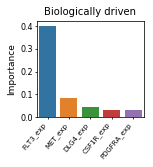

In [126]:
# Plot top k features along with their importances
k = 5

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

ax = sns.barplot(x=xs, y=ys, orient="v")
ax.set_ylabel("Importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(axis="x", labelsize=7)
ax.set_title("Biologically driven", fontsize=10)

plt.tight_layout()

plt.savefig(fig_directory + "fig7_feat_imp_restricted_" + drug_name)
plt.savefig(gimp_directory + "fig7_feat_imp_restricted_" + drug_name)

plt.show()

#### Panel 3 - Feature importance - GW EN model

In [128]:
# Load genome-wide ENet ModelingResult object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "genome_wide-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
    genome_wide_without_selection_enet = dill.load(f)
print(type(genome_wide_without_selection_enet), 
      len(genome_wide_without_selection_enet.feat_importances_dict))

<class 'gdsc_projects_module.ModelingResults'> 10


In [129]:
# Load previously computed feature importances
drug_name = "Dabrafenib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]

cols = [x[0] for x in importances]
importances = [-x[1] for x in importances]
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc, normalize=True)

print(len(sorted_importances), sorted_importances[:3])

17737 [('MMP8_exp', 0.014689349283674784), ('GAPDHS_exp', 0.01105896717434309), ('ACTBL2_exp', 0.006943687485143574)]


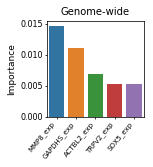

In [130]:
# Plot top k features along with their importances
k = 5

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

ax = sns.barplot(x=xs, y=ys, orient="v")
ax.set_ylabel("Importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(axis="x", labelsize=7)
ax.set_title("Genome-wide", fontsize=10)


plt.tight_layout()

plt.savefig(fig_directory + "fig7_feat_imp_gw_" + drug_name)
plt.savefig(gimp_directory + "fig7_feat_imp_gw_" + drug_name)

plt.show()

In [131]:
importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]

In [132]:
importances[:5]

[('MMP8_exp', -0.017261867929832454),
 ('GAPDHS_exp', -0.012995703697781935),
 ('ACTBL2_exp', -0.008159722667074713),
 ('TRPV2_exp', -0.0062568255451654784),
 ('SOX5_exp', -0.00619509604923343)]

# Check feature importances

#### Genome-wide

In [13]:
# Load DataFrame with drugs of interest
df_doi = pd.read_csv("./Results and other files/drugs_of_interest.csv")
print(df_doi.shape)

(10, 10)


In [16]:
# Load genome-wide ENet ModelingResult object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "genome_wide-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
    genome_wide_without_selection_enet = dill.load(f)
print(type(genome_wide_without_selection_enet), 
      len(genome_wide_without_selection_enet.feat_importances_dict))

<class 'gdsc_projects_module.ModelingResults'> 10


In [17]:
# Load previously computed feature importances
drug_name = "Linifanib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]

cols = [x[0] for x in importances]
importances = [-x[1] for x in importances]
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc, normalize=True)

print(len(sorted_importances), sorted_importances[:3])

17737 [('OCSTAMP_exp', 0.01246889026864675), ('PPP1R27_exp', 0.007208430051411637), ('CSF1R_exp', 0.005650626456957644)]


In [18]:
names = [x[0] for x in sorted_importances]
print(len(names))
names.index("FLT3_exp") + 1

17737


11

In [19]:
for el in sorted_importances:
    print(el)
    time.sleep(1)

('OCSTAMP_exp', 0.01246889026864675)
('PPP1R27_exp', 0.007208430051411637)
('CSF1R_exp', 0.005650626456957644)
('TIFAB_exp', 0.005632204394451128)
('CD300LF_exp', 0.005523347731832171)
('SIGLEC7_exp', 0.004754571673512108)
('RETN_exp', -0.004386135427190893)
('LILRB2_exp', 0.004267298245916722)
('DEFA4_exp', -0.004247266210815239)
('EFHC2_exp', 0.003305162100991933)
('FLT3_exp', 0.0029691682783294375)
('TRH_exp', 0.0028964819079694763)
('CX3CR1_exp', 0.002658810882382431)
('PIK3R5_exp', 0.0022593532817760005)
('CIB3_exp', 0.0021894788600866767)
('PPM1F_exp', 0.001946537470087352)
('DLEU7_exp', -0.0018654667403450356)


KeyboardInterrupt: 

In [21]:
0.01246889026864675 / 0.0029691682783294375

4.199455571329963

#### Restricted

# Supplementary figures